In [1]:
from libraries import lib
from libraries.NeuralStates import MHNeuralState
import qutip as qt
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

In [2]:
h = lib.TFIM_hamiltonian(10, 1, 1)

In [3]:
h

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape=(1024, 1024), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-10.  -1.  -1. ...   0.   0.   0.]
 [ -1.  -6.   0. ...   0.   0.   0.]
 [ -1.   0.  -6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  -6.   0.  -1.]
 [  0.   0.   0. ...   0.  -6.  -1.]
 [  0.   0.   0. ...  -1.  -1. -10.]]

In [4]:
h.__reduce__()

(<function copyreg._reconstructor(cls, base, state)>,
 (qutip.core.qobj.Qobj, object, None),
 {'_isherm': True,
  '_isunitary': None,
  '_data': CSR(shape=(1024, 1024), nnz=11264),
  '_dims': Dimensions(Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2)), Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2))),
  'qutip_version': '5.0.4'})

In [5]:
vec = qt.tensor([qt.basis(2, 0)] * 10)
vec.__reduce__()

(<function copyreg._reconstructor(cls, base, state)>,
 (qutip.core.qobj.Qobj, object, None),
 {'_isherm': None,
  '_isunitary': None,
  '_data': Dense(shape=(1024, 1), fortran=True),
  '_dims': Dimensions(Compound(Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field(), Field()), Compound(Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2), Space(2))),
  'qutip_version': '5.0.4'})

In [6]:
# vec.dtype = qt.data.CSR

In [7]:
def f(x):
    return np.exp(-x ** 2) * (2 + np.sin(5*x)+np.sin(2*x))

In [8]:
def MH_continuous(p, x_func, x0, num_samples, burnin = 0, lag = 0):
    x = x0
    data = [x] 
    for _ in range(burnin):
        new_x = x_func(x)
        ratio = p(new_x) / p(x)
        if ratio > 1 or ratio > npr.uniform(0, 1):
            x = new_x
    for _ in range(num_samples):
        for _ in range(lag):
            new_x = x_func(x)
            ratio = p(new_x) / p(x)
            if ratio > 1 or ratio > npr.uniform(0, 1):
                x = new_x
        new_x = x_func(x)
        ratio = p(new_x) / p(x)
        if ratio > 1 or ratio > npr.uniform(0, 1):
            data.append(new_x)
            x = new_x 
        else: 
            data.append(x)
    return data

In [9]:
samples = 10000
data = MH_continuous(f, lambda x : npr.normal(x, 1), 0, samples, burnin = 50, lag = 0)

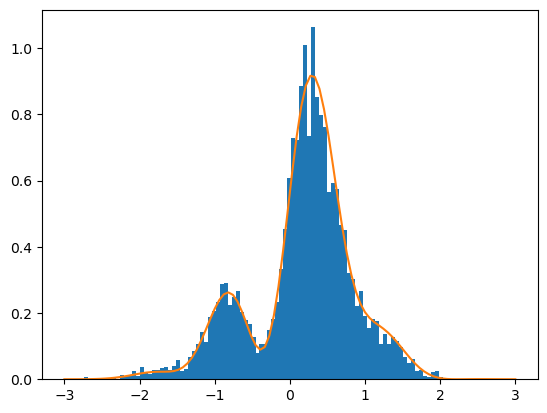

In [10]:
hist = plt.hist(data, density = True, bins = 100)
# for i in range(len(hist[0])):
#     hist[0][i] = hist[0][i] / samples
# # plt.clf()
# hist
x = np.linspace(-3, 3, 100)
norm = np.trapezoid(x, f(x))
plt.plot(x, - f(x) / norm)
plt.show()

In [11]:
from scipy.special import factorial
def poisson(k, lmd):
    return np.exp(-lmd) * lmd ** k / factorial(k)

In [12]:
def sample_x(x, sigma, bounds = (float('-inf'), float('inf'))):
    new_x = round(npr.normal(x, sigma)) % (bounds[1] + 1)
    # new_x = (x + [-1, 1][npr.randint(0, 2)]) % (bounds[1] + 1)
    # print(new_x)
    return new_x

In [13]:
samples = 10000
lmd = 5
data = MH_continuous(lambda x : poisson(x, lmd), 
                     lambda x : sample_x(x, 2, (0, float('inf'))), 
                     5, samples)

C:\Users\taoha\AppData\Local\Temp\ipykernel_24848\1483049671.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-lmd) * lmd ** k / factorial(k)


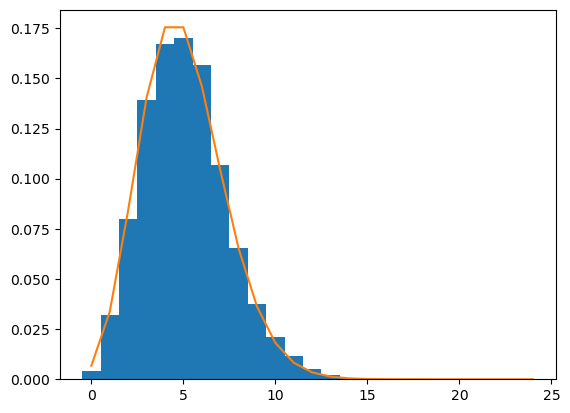

In [14]:
hist = plt.hist(data, density = True, bins = [-0.5 + n for n in range(0, 20)])
x = np.array([n for n in range(0, 25)])
y = poisson(x, lmd)
norm = np.trapezoid(x, y)
plt.plot(x, y)
plt.show()

In [15]:
N = 5

In [16]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [17]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [18]:
input = lib.generate_input_torch(N)
model_state = lib.model_to_ground_state(model, input, amp_phase)

In [19]:
model_state

Quantum object: dims=[[32], [1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[-0.17680608-0.01426087j]
 [-0.17118336-0.01266131j]
 [-0.17544368-0.00973457j]
 [-0.16992028-0.00883617j]
 [-0.17020227-0.00892282j]
 [-0.1645081 -0.00796346j]
 [-0.16874065-0.00514171j]
 [-0.16313365-0.0047627j ]
 [-0.18553171-0.01800259j]
 [-0.17986625-0.01582166j]
 [-0.18394595-0.01304446j]
 [-0.17833328-0.01201416j]
 [-0.1791115 -0.01299659j]
 [-0.17333487-0.01140944j]
 [-0.17760642-0.00932482j]
 [-0.17187792-0.00876927j]
 [-0.18063606-0.01250648j]
 [-0.17486437-0.01205062j]
 [-0.17918885-0.00861807j]
 [-0.17350504-0.00917602j]
 [-0.1742312 -0.00751876j]
 [-0.16847068-0.00834545j]
 [-0.17290147-0.00479481j]
 [-0.16719329-0.0063558j ]
 [-0.18932986-0.01627444j]
 [-0.18381298-0.01505719j]
 [-0.18778594-0.01235319j]
 [-0.18227273-0.01263028j]
 [-0.1829478 -0.01156013j]
 [-0.17733869-0.01160903j]
 [-0.18167122-0.00932143j]
 [-0.17603627-0.01058435j]]

In [20]:
np.abs(np.squeeze(model_state.full())) ** 2

array([0.03146376, 0.02946405, 0.03087525, 0.02895098, 0.02904843,
       0.02712633, 0.02849984, 0.02663527, 0.03474611, 0.03260219,
       0.03400627, 0.0319471 , 0.03224984, 0.03017515, 0.03163099,
       0.02961892, 0.0327858 , 0.03072276, 0.03218291, 0.0301882 ,
       0.03041304, 0.02845202, 0.02991791, 0.02799399, 0.03611065,
       0.03401393, 0.03541616, 0.03338287, 0.03360353, 0.03158378,
       0.03309132, 0.0311008 ])

In [21]:
model_state.dag() @ model_state

(1.0000001748980523+0j)

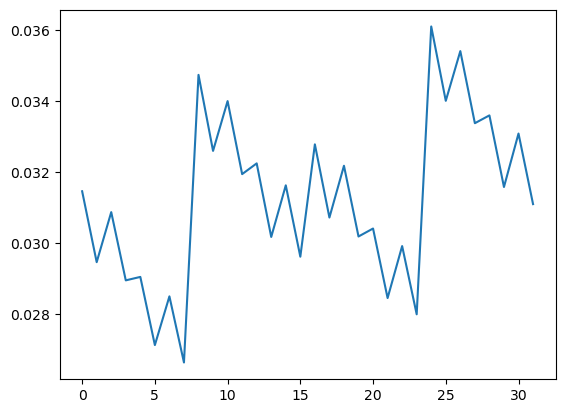

In [22]:
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [23]:
model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : sample_x(x, 20, (0, 2 ** N - 1)), 5, 256, lag = 0)
# it seems that N ** 4 samples is pretty good

c:\Users\taoha\OneDrive\Documents\GitHub\kans-urop\MHNeuralState.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  tens = torch.tensor([lib.generate_state_1D(x, N)], dtype = torch.float32)


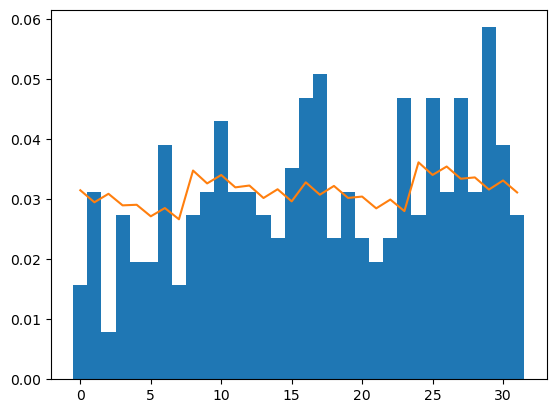

In [24]:
hist = plt.hist(model_MH.distribution_to_list(), density = True, bins = [-0.5 + n for n in range(0, 2 ** N + 1)])
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [25]:
from libraries.NeuralStates import SparseStateVector

In [26]:
SparseStateVector.inner_product(model_MH, model_MH)

tensor(3.2653+0.j, grad_fn=<AddBackward0>)

In [27]:
J = 1
Gamma = 1

In [28]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-4.9979, grad_fn=<DivBackward0>)

In [29]:
SparseStateVector.TFIM_expectation_from_sparse(model_MH, N, J, Gamma).real

tensor(-4.9979, grad_fn=<SelectBackward0>)

In [30]:
# training with all inputs and then testing Metropolis
vars = (N, J, Gamma)
loss_fn = lib.TFIM_expectation_from_torch
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 2)
for epoch in range(1000):
    y_pred = model(input)
    loss = loss_fn(y_pred, vars, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)


In [31]:
lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[0][0]

np.float64(-6.472135954999574)

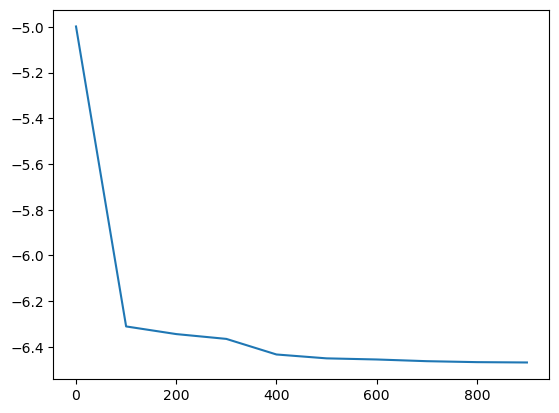

In [32]:
plt.plot(epochs, loss_data)

In [33]:
loss_data[-1]

-6.468244552612305

In [35]:
model_state = lib.model_to_ground_state(model, input, amp_phase)
model_state

Quantum object: dims=[[32], [1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[-0.14555617-0.50264055j]
 [-0.04207233-0.14434873j]
 [-0.04488357-0.15386644j]
 [-0.03059052-0.10300315j]
 [-0.04183611-0.14405026j]
 [-0.01449953-0.04978452j]
 [-0.03027135-0.10295929j]
 [-0.03025014-0.10163149j]
 [-0.04579449-0.15768988j]
 [-0.016137  -0.05520338j]
 [-0.01767984-0.05892679j]
 [-0.0170764 -0.05649475j]
 [-0.03112646-0.10499319j]
 [-0.01661027-0.05609167j]
 [-0.03174012-0.10890311j]
 [-0.04678457-0.15917277j]
 [-0.04287314-0.14733267j]
 [-0.02876506-0.09795462j]
 [-0.01602195-0.05494911j]
 [-0.03044833-0.10415411j]
 [-0.01497552-0.05153993j]
 [-0.015458  -0.05342799j]
 [-0.01657677-0.05500314j]
 [-0.04524658-0.15204582j]
 [-0.0313663 -0.10762187j]
 [-0.03150809-0.10653263j]
 [-0.01735124-0.05909156j]
 [-0.04781587-0.1615604j ]
 [-0.03187358-0.10630316j]
 [-0.04573962-0.15411976j]
 [-0.04829387-0.16214217j]
 [-0.16060987-0.54027885j]]

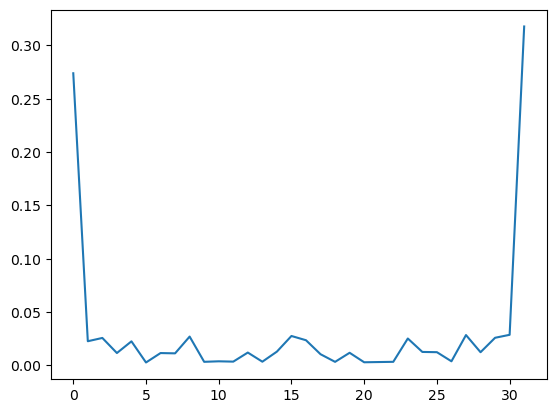

In [36]:
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [37]:
model_MH = MHNeuralState(N, model, amp_phase, lambda x : sample_x(x, 3, (0, 2 ** N - 1)), 5, 250, 50)

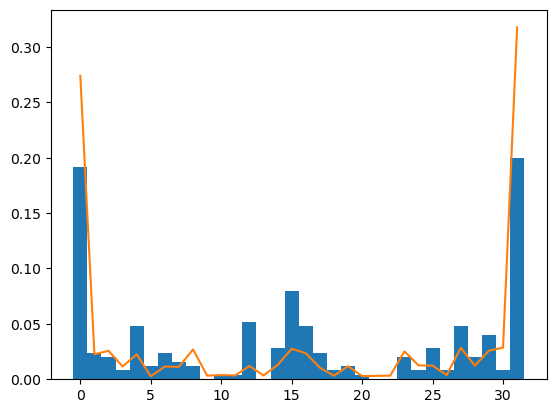

In [38]:
hist = plt.hist(model_MH.distribution_to_list(), density = True, bins = [-0.5 + n for n in range(0, 2 ** N + 1)])
plt.plot([n for n in range(0, 2 ** N)], np.abs(np.squeeze(model_state.full())) ** 2)
plt.show()

In [39]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-6.4701, grad_fn=<DivBackward0>)

In [41]:
SparseStateVector.TFIM_expectation_from_sparse(model_MH, N, J, Gamma)

tensor(-6.4701, grad_fn=<SelectBackward0>)